# Translating the summarized text

In [ ]:
with open('summarized_text.txt','r') as t:
  sum_text= t.read()

In [ ]:
!pip install translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install deep_translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(sum_text)

hello, my name is food toxicology would like to welcome back once again. one of the answers, one of the responses is to establish standards of behavior, standards of practice and legal standards so that we have a safe and pure food supply. these were highlighted in many, many national Publications like Good Housekeeping magazine. what he did, in fact, was to expand this Bureau chemistry staff and capability. it would be neat stored and great piles and thousands of rats would race about on it. we had mandatory inspection of livestock before Slaughter. we had sanitary standards established for slaughterhouses and meat processing plants in and actually authorize the USDA to do ongoing monitoring, inspection, Slaughter and processing operations. these first 1906 acts of Meat Inspection are actually with us today. okay, so this is 100 years old now we've 100 Years of history of Meat Inspection. and so what we found in this particular incident was many deaths are. nobody but almighty God and

In [ ]:
from deep_translator import GoogleTranslator
translated = GoogleTranslator(source='english', target='spanish').translate_file('summarized_text.txt')
print(translated)

hola, mi nombre es toxicología alimentaria me gustaría darle la bienvenida una vez más. una de las respuestas, una de las respuestas es establecer estándares de comportamiento, estándares de práctica y estándares legales para que tengamos un suministro de alimentos puro y seguro. estos fueron destacados en muchas, muchas publicaciones nacionales como la revista Good Housekeeping. lo que hizo, de hecho, fue ampliar la capacidad y el personal de química de la Oficina. se almacenaría ordenadamente y grandes montones y miles de ratas correrían sobre él. teníamos inspección obligatoria del ganado antes del Sacrificio. establecimos estándares sanitarios para mataderos y plantas de procesamiento de carne y, de hecho, autorizamos al USDA a realizar operaciones continuas de monitoreo, inspección, sacrificio y procesamiento. estos primeros actos de Inspección de Carnes de 1906 están realmente con nosotros hoy. Bien, esto tiene 100 años, ahora tenemos 100 años de historia de inspección de carne. 

In [ ]:
from deep_translator import GoogleTranslator
translated = GoogleTranslator(source='english', target='german').translate_file('summarized_text.txt')
print(translated)

hallo, mein name ist lebensmitteltoxikologie möchte mich wieder einmal herzlich willkommen heißen. Eine der Antworten, eine der Antworten ist, Verhaltensstandards, Praxisstandards und gesetzliche Standards festzulegen, damit wir eine sichere und reine Lebensmittelversorgung haben. diese wurden in vielen, vielen nationalen Publikationen wie dem Good Housekeeping Magazin hervorgehoben. Was er tatsächlich tat, war, das Personal und die Fähigkeiten dieses Büros für Chemie zu erweitern. es würde ordentlich gelagert werden und große Haufen und Tausende von Ratten würden darauf herumrennen. Wir hatten eine obligatorische Inspektion des Viehbestands vor der Schlachtung. Wir haben Hygienestandards für Schlachthöfe und Fleischverarbeitungsbetriebe eingeführt und ermächtigen das USDA tatsächlich, laufende Überwachungs-, Inspektions-, Schlacht- und Verarbeitungsvorgänge durchzuführen. Diese ersten Akten der Fleischbeschau von 1906 sind heute noch bei uns. Okay, das ist also 100 Jahre alt, jetzt ha

In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [ ]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    #textfile
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2638744/2638744 [==============================] - 0s 0us/step


In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [ ]:
#splitting into train and test data
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [ ]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


In [ ]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
epochs = 10 

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

KeyboardInterrupt: ignored

We are interuptting it after 4 epochs.


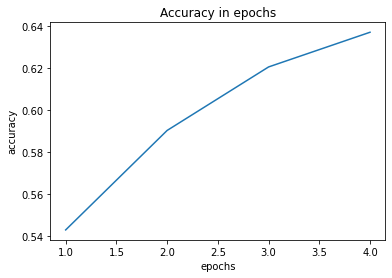

In [ ]:
import matplotlib.pyplot as plt
epochValues = [i+1 for i in range(4)]
epoch_accuracies = [0.5431,0.5904,0.6206,0.6371]
epoch_loses = [1.3149,1.1628,1.0816,1.0450]
plt.plot(epochValues, epoch_accuracies)
plt.title('Accuracy in epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

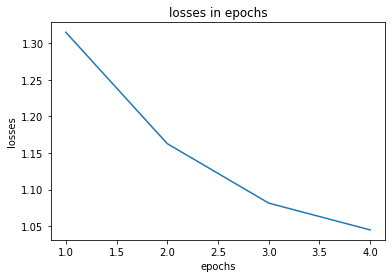

In [ ]:
import matplotlib.pyplot as plt
epochValues = [i+1 for i in range(4)]
epoch_accuracies = [0.5431,0.5904,0.6206,0.6371]
epoch_loses = [1.3149,1.1628,1.0816,1.0450]
plt.plot(epochValues, epoch_loses)
plt.title('losses in epochs')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.show()

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

#printing the translating texts for each sentence of the summary
test_eng_texts = [pair[0] for pair in test_pairs]
arrayOftext = sum_text.split('.')
for i in range(len(arrayOftext)):
    input_sentence = arrayOftext[i]
    translated = decode_sequence(input_sentence)
print(translated)

[start] colonia encontrarse motores lavarte galileo suavemente incentivó enterraron bello insectos enseñará plástico encendidas fugaz empeoró cumple hoy hago rentar gratuito
